### 1. Pretraining

In [1]:
from pathlib import Path
# augmentation methods
from src.otus_project_dev.augmentation import pre_transforms, post_transforms, hard_transforms, compose
# dataset creator based on torch.utils.data.dataset.Dataset
from src.otus_project_dev.dataset import SegmentationDataset, get_loaders
# sample visualizer
from src.otus_project_dev.visualization import draw_sample

In [2]:
CLASSES = [0, 29, 76, 105, 128, 150, 179, 211, 226, 255]

Data

In [3]:
ROOT = Path("./data/CelebAMask-HQ/")

train_image_path = ROOT / "CelebA-HQ-img"
train_mask_path = ROOT / "mask"

ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

Augmentations

In [4]:
train_transforms = compose([
    pre_transforms(),
    hard_transforms(),
    post_transforms(CLASSES),
])
valid_transforms = compose([pre_transforms(), post_transforms(CLASSES)])

Dataset

In [5]:
batch_size = 48
random_state = 16

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    classes=CLASSES,
    random_state=random_state,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


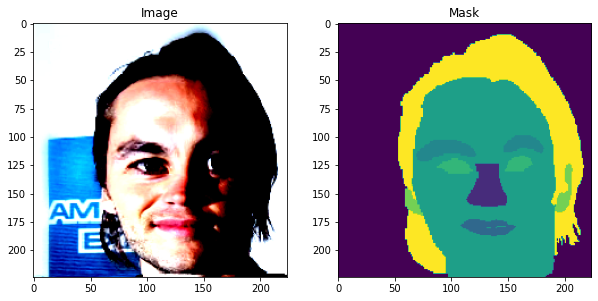

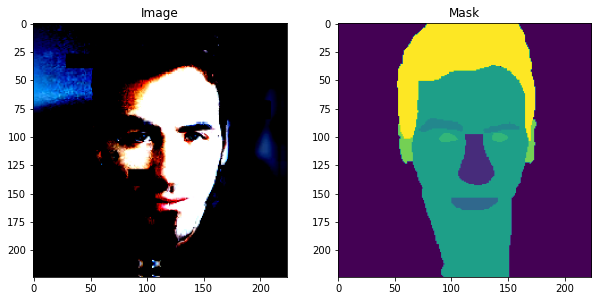

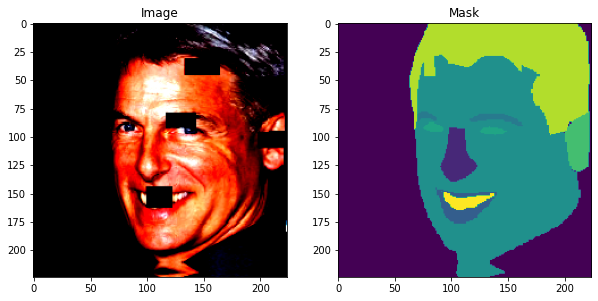

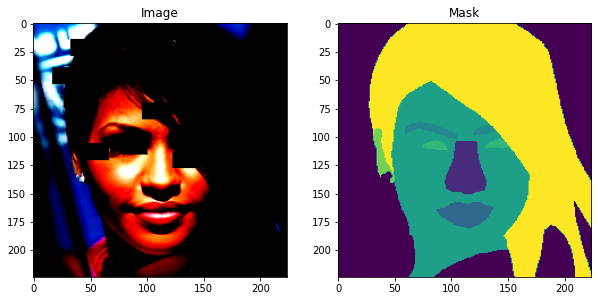

In [6]:
dataloader_iterator = iter(loaders["train"])
batch = next(dataloader_iterator)
for i in range (min(len(batch["image"])-1, 4)):
    draw_sample(batch["image"][i], batch["mask"][i], CLASSES, is_tensor=True)

Model

In [7]:
import segmentation_models_pytorch as smp
aux_params= None
model = smp.FPN(encoder_name="mobilenet_v2", decoder_dropout=0.5, classes=len(CLASSES), aux_params=aux_params)

Learning parameters

In [8]:
from torch import nn
from catalyst.contrib.nn import DiceLoss, IoULoss, FocalLossBinary
# multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(threshold=0.5),
    "bce": nn.BCEWithLogitsLoss(),
    "focal": FocalLossBinary(threshold=0.5, gamma=1)
}

In [9]:
from catalyst import utils
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

encoder_learning_rate = 0.001
# weight_decay - parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.0001)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box (RAdam)
learning_rate = 0.001
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0001)
optimizer = Lookahead(base_optimizer)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

Train

In [10]:
from catalyst.dl import SupervisedRunner

num_epochs = 10
logdir = "./logs/segmentation/mobilenet_v2_celebHQ"
device = utils.get_device()
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [11]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_focal",
        criterion_key="focal"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8, "loss_focal":1.0},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [12]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=None,
    # prints train logs
    verbose=True,
)

1/10 * Epoch (train): 100% 500/500 [07:40<00:00,  1.09it/s, dice=0.859, iou=0.753, loss=0.421, loss_bce=0.070, loss_dice=0.141, loss_focal=0.026, loss_iou=0.198]
1/10 * Epoch (valid): 100% 125/125 [01:47<00:00,  1.17it/s, dice=0.910, iou=0.834, loss=0.283, loss_bce=0.044, loss_dice=0.090, loss_focal=0.016, loss_iou=0.142]
[2020-10-04 02:05:22,775] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): dice=0.7421 | iou=0.6101 | loss=0.8277 | loss_bce=0.1844 | loss_dice=0.2579 | loss_focal=0.0879 | loss_iou=0.3343
1/10 * Epoch 1 (valid): dice=0.9096 | iou=0.8343 | loss=0.2831 | loss_bce=0.0438 | loss_dice=0.0904 | loss_focal=0.0154 | loss_iou=0.1422
2/10 * Epoch (train): 100% 500/500 [08:11<00:00,  1.02it/s, dice=0.895, iou=0.809, loss=0.328, loss_bce=0.056, loss_dice=0.105, loss_focal=0.022, loss_iou=0.156]
2/10 * Epoch (valid): 100% 125/125 [01:44<00:00,  1.19it/s, dice=0.927, iou=0.863, loss=0.232, loss_bce=0.037, loss_dice=0.073, loss_focal=0.014, loss_iou=0.11

/home/kuskov/anaconda3/envs/otus_cv/lib/python3.8/site-packages/catalyst/core/callbacks/optimizer.py:137: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)

